# Prototipo simulador parte 4: control respiratorio

In [1]:
# Librerías
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Estilo
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
class Paciente:
    """Clase que define un paciente con parámetros normales;
    para agregar pacientes con patologías, crear una subclase con modificaciones
    en los parámetros específicos que haga falta"""
    def __init__(self, R1=5, C1=0.05, R2=10, C2=0.05):
        self.R1 = R1
        self.C1 = C1
        self.R2 = R2
        self.C2 = C2
        self.E1 = 1 / self.C1
        self.E2 = 1 / self.C2

In [3]:
class Ventilador:
    """Parámetros y perfiles de ventilación mecánica."""
    def __init__(self,
                 modo: str = 'PCV',
                 PEEP: float = 5.0,
                 P_driving: float = 15.0,
                 fr: float = 20.0,
                 Ti: float = 1.0,
                 Vt: float = None):
        self.modo = modo
        self.PEEP = PEEP
        self.P_driving = P_driving
        self.fr = fr
        self.Ti = Ti
        self.T_total = 60.0 / fr
        self.Vt = Vt
        if modo == 'VCV':
            assert Vt is not None, "Se requiere Vt para modo VCV"
            self.flow_insp = Vt / Ti
        else:
            self.flow_insp = None

    def presion(self, t: float) -> np.ndarray:
        """Perfil de presión en la vía aérea según el modo y el tiempo t."""
        t_arr = np.asarray(t)
        en_insp = (t_arr % self.T_total) < self.Ti
        if self.modo == 'PCV':
            P_control = self.PEEP + self.P_driving
            return np.where(en_insp, P_control, self.PEEP)
        elif self.modo == 'VCV':
            return np.full_like(t_arr, self.PEEP)
        else:
            raise ValueError(f"Modo desconocido: {modo}")

    def flujo(self, t: float) -> np.ndarray:
        """Perfil de flujo inspirado en VCV, 0 fuera de inspiración."""
        if self.modo != 'VCV':
            return np.zeros_like(np.asarray(t))
        t_arr = np.asarray(t)
        return np.where((t_arr % self.T_total) < self.Ti, self.flow_insp, 0.0)

In [4]:
class Simulador:
    """Orquesta la simulación paciente-ventilador."""
    def __init__(self,
                 paciente: Paciente,
                 ventilador: Ventilador,
                 control: 'ControlRespiratorio' = None):
        self.paciente = paciente
        self.ventilador = ventilador
        self.control = control
        if ventilador.modo == 'ESP':
            assert self.control is not None, "Se requiere un módulo de ControlRespiratorio para el modo 'ESP'"

    def _modelo_edo(self, t, y):
        V1, V2 = y

        if self.ventilador.modo == 'ESP':
            # En modo espontáneo, la presión la genera el módulo de control
            P_aw = self.control.generar_Pmus(t)
        elif self.ventilador.modo == 'VCV':
            # Lógica para VCV
            en_insp = (t % self.ventilador.T_total) < self.ventilador.Ti
            flow_total = np.where(en_insp, self.ventilador.flow_insp, 0.0)
            P_aw_insp = (flow_total + (self.paciente.E1 * V1 / self.paciente.R1) + (self.paciente.E2 * V2 / self.paciente.R2)) / ((1.0 / self.paciente.R1) + (1.0 / self.paciente.R2))
            P_aw = np.where(en_insp, P_aw_insp, self.ventilador.PEEP)
        elif self.ventilador.modo == 'PCV':
            # Lógica para PCV
            P_aw = self.ventilador.presion(t)
        else:
            raise ValueError(f"Modo desconocido: {self.ventilador.modo}")

        # Se calculan las derivadas dV/dt (sin cambios)
        dV1_dt = (P_aw - self.paciente.E1 * V1) / self.paciente.R1
        dV2_dt = (P_aw - self.paciente.E2 * V2) / self.paciente.R2

        return [dV1_dt, dV2_dt]

    def simular(self,
                num_ciclos: int=15,
                pasos_por_ciclo: int = 100):
        """Ejecuta múltiples ciclos y devuelve t, V1 y V2 concatenados."""
        t_data, V1_data, V2_data = [], [], []
        V0 = [0.0, 0.0]
        for i in range(num_ciclos):
            t0 = i * self.ventilador.T_total
            t1 = (i + 1) * self.ventilador.T_total
            if i < num_ciclos-1: #corrección para evitar discontinuidad en t=3.0
                t_eval = np.linspace(t0, t1, pasos_por_ciclo, endpoint=False)
            else:
                t_eval = np.linspace(t0, t1, pasos_por_ciclo, endpoint=True)
            sol = solve_ivp(self._modelo_edo,
                            [t0, t1],
                            V0,
                            t_eval=t_eval)
            t_data.append(sol.t)
            V1_data.append(sol.y[0])
            V2_data.append(sol.y[1])
            V0 = sol.y[:, -1]
        t = np.concatenate(t_data)
        V1 = np.concatenate(V1_data)
        V2 = np.concatenate(V2_data)
        return t, V1, V2

    def procesar_resultados(self,
                            t: np.ndarray,
                            V1: np.ndarray,
                            V2: np.ndarray) -> dict:
        """Calcula flujo, volumen total y presión resultante."""
        flujo1 = np.gradient(V1, t)
        flujo2 = np.gradient(V2, t)
        flujo_total = flujo1 + flujo2
        Vt = V1 + V2
        if self.ventilador.modo == 'PCV':
            P_aw = self.ventilador.presion(t)
        else:
            P_aw = ((flujo_total
                     + (self.paciente.E1 * V1 / self.paciente.R1)
                     + (self.paciente.E2 * V2 / self.paciente.R2))
                    / ((1 / self.paciente.R1) + (1 / self.paciente.R2)))
        return {
            't': t,
            'V1': V1,
            'V2': V2,
            'Vt': Vt,
            'flow1': flujo1,
            'flow2': flujo2,
            'flow': flujo_total,
            'P_aw': P_aw
        }

    def graficar_resultados(self,
                            resultados: dict,
                            titulo: str = 'Simulación Pulmonar'):
        """Grafica presión, flujo total y volumen total a partir del diccionario
        de resultados."""
        t = resultados['t']
        P_aw = resultados['P_aw']
        flujo = resultados['flow']
        Vt = resultados['Vt']

        fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
        fig.suptitle(titulo, fontsize=16)

        # Presión
        axs[0].plot(t, P_aw, color='red', label='Presión (P_aw)')
        axs[0].set_ylabel('Presión (cmH2O)')
        axs[0].legend()

        # Flujo
        axs[1].plot(t, flujo, color='blue', label='Flujo Total')
        axs[1].set_ylabel('Flujo (L/s)')
        axs[1].axhline(0, color='grey', linewidth=0.8)
        axs[1].legend()

        # Volumen
        axs[2].plot(t, Vt, color='green', label='Volumen (L)')
        axs[2].set_ylabel('Volumen (L)')
        axs[2].set_xlabel('Tiempo (s)')
        axs[2].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

In [5]:
class IntercambioGases:
    """
    Módulo de intercambio gaseoso alveolar.
    Calcula presiones de CO2 y O2 alveolares a partir de los resultados
    de la simulación de mecánica respiratoria.
    """
    def __init__(
        self,
        ventilador,
        V_D: float,
        VCO2: float,
        R: float,
        FiO2: float,
        Pb: float,
        PH2O: float = 47.0,
        K: float = 0.863
    ):
        self.ventilador = ventilador
        self.V_D = V_D      # volumen muerto anatómico (L)
        self.VCO2 = VCO2    # producción de CO2 (mL/min)
        self.R = R          # cociente respiratorio (adimensional)
        self.FiO2 = FiO2    # fracción inspirada de O2 (0-1)
        self.Pb = Pb        # presión barométrica (mmHg)
        self.PH2O = PH2O    # presión vapor de agua a 37°C (mmHg)
        self.K = K          # constante de conversión de unidades

    def calcular(self, resultados: dict) -> dict:
        """
        Ejecuta el cálculo de intercambio gaseoso.

        Parámetros
        ----------
        resultados : dict
            Diccionario de salida de Simulador.procesar_resultados(),
            con claves 't' (tiempo) y 'Vt' (volumen total alveolar, L).

        Devuelve
        -------
        dict con:
            VE_min: ventilación minuto total (L/min)
            VA_min: ventilación minuto alveolar (L/min)
            PACO2_mmHg: presión alveolar de CO2 (mmHg)
            PAO2_mmHg: presión alveolar de O2 (mmHg)
        """
        t = resultados['t']
        # 1. Frecuencia respiratoria (ciclos/min)
        f = self.ventilador.fr

        # 2. Volumen tidal (L)
        if self.ventilador.modo == 'VCV':
            VT = self.ventilador.Vt
        else:
            # Para modos espontáneos o PCV, calculamos el VT promedio
            # integrando el flujo inspiratorio sobre el período de simulación.
            flujo = resultados['flow']

            # 1. Identificar el flujo inspiratorio
            flujo_inspiratorio = np.maximum(0, flujo)

            # 2. Integrar el flujo para obtener el volumen total inspirado en el chunk
            volumen_inspirado_total = np.trapezoid(flujo_inspiratorio, t)

            # 3. Calcular el número de respiraciones en el chunk
            duracion_chunk = t[-1] - t[0]
            num_respiraciones = duracion_chunk * (f / 60.0) # f está en rpm, t en seg

            # 4. Calcular el VT promedio (evitando división por cero)
            if num_respiraciones > 0:
                VT = volumen_inspirado_total / num_respiraciones
            else:
                VT = 0

            # --- INICIO DE BLOQUE DE DEPURACIÓN ---
            print(f"    [DEBUG] Vol. Inspirado Total: {volumen_inspirado_total:.3f} L")
            print(f"    [DEBUG] Num. Respiraciones: {num_respiraciones:.2f}")
            print(f"    [DEBUG] VT Promedio Calculado: {VT:.3f} L")
            # --- FIN DE BLOQUE DE DEPURACIÓN ---

        # 3. Ventilaciones minuto
        VE = VT * f
        VA = (VT - self.V_D) * f

        # --- DEPURACIÓN ADICIONAL ---
        print(f"    [DEBUG] Ventilación Alveolar (VA): {VA:.2f} L/min")
        # --- FIN DE DEPURACIÓN ---

        if VA <= 0:  #ocurre sólo si el VT es realmente muy bajo.
            raise ValueError("Ventilación alveolar ≤ 0, revisa V_D o simulación.")

        # 4. Presión alveolar de CO2 (mmHg)
        PACO2 = (self.VCO2 * self.K) / VA

        # 5. Presión alveolar de O2 (mmHg)
        PIO2 = self.FiO2 * (self.Pb - self.PH2O)
        PAO2 = PIO2 - (PACO2 / self.R)

        return {
            'VE_min': VE,
            'VA_min': VA,
            'PACO2_mmHg': PACO2,
            'PAO2_mmHg': PAO2
        }


In [6]:
class InteraccionCorazonPulmon:
    """
    Módulo de interacción hemodinámica corazón-pulmón.

    Modela el efecto de la presión en la vía aérea sobre el gasto cardíaco y la
    entrega de oxígeno.
    """
    def __init__(
        self,
        GC_base_L_min: float = 5.0,
        k_sensibilidad: float = 0.1,
        hb_g_dl: float = 15.0
    ):
        """
        Inicializa el estado cardiovascular basal del paciente.

        Parámetros
        ----------
        GC_base_L_min : float
            Gasto cardíaco basal del paciente en L/min.
        k_sensibilidad : float
            Factor de sensibilidad hemodinámica a la presión intratorácica.
            Un valor bajo (~0.05-0.1) simula un paciente normovolémico.
            Un valor alto (>0.2) simula un paciente hipovolémico o con disfunción cardíaca.
        hb_g_dl : float
            Concentración de hemoglobina en g/dL.
        """
        self.GC_base_L_min = GC_base_L_min
        self.k_sensibilidad = k_sensibilidad
        self.hb_g_dl = hb_g_dl
        # Constantes fisiológicas
        self.O2_CAP_HB = 1.34  # Capacidad de O2 por gramo de Hb (mL O2/g Hb)
        self.O2_SOL_PLASMA = 0.003  # Solubilidad de O2 en plasma (mL O2/dL/mmHg)

    def _estimar_sao2(self, pao2: float) -> float:
        """
        Estima la SaO2 a partir de la PaO2 usando una aproximación simple.
        NOTA: Simplificación educativa que no implementa la curva de disociación
        de la hemoglobina (Ecuación de Hill).
        """
        if pao2 >= 100:
            return 1.0
        elif pao2 >= 60:
            # Aproximación lineal груба entre 90% (a 60 mmHg) y 100% (a 100 mmHg)
            return 0.90 + 0.10 * ((pao2 - 60) / 40)
        else:
            # Aproximación para hipoxemia severa
            return 0.90 * (pao2 / 60)

    def calcular(
        self,
        resultados_mecanica: dict,
        resultados_gases: dict,
        ventilador: Ventilador
    ) -> dict:
        """
        Calcula el impacto hemodinámico de la ventilación mecánica.

        Parámetros
        ----------
        resultados_mecanica : dict
            El diccionario de salida de Simulador.procesar_resultados().
        resultados_gases : dict
            El diccionario de salida de IntercambioGases.calcular().
        ventilador : Ventilador
            La instancia del ventilador para obtener el PEEP.

        Devuelve
        -------
        dict con los resultados cardiovasculares:
            P_mean_cmH2O: Presión media en la vía aérea calculada.
            GC_actual_L_min: Gasto cardíaco resultante.
            PaO2_mmHg: Presión arterial de O2 estimada.
            SaO2_percent: Saturación arterial de O2 estimada.
            CAO2_ml_dl: Contenido arterial de O2.
            DO2_ml_min: Entrega de oxígeno a los tejidos.
        """
        t = resultados_mecanica['t']
        P_aw = resultados_mecanica['P_aw']
        PAO2_mmHg = resultados_gases['PAO2_mmHg']

        # 1. Calcular Presión Media en la Vía Aérea (P_mean)
        # Se integra el área bajo la curva de presión y se divide por la duración
        tiempo_total_ciclo = t[-1] - t[-2-1] if len(t)>1 else t[-1]
        p_aw_ultimo_ciclo = P_aw[t >= t[-1] - tiempo_total_ciclo]
        t_ultimo_ciclo = t[t >= t[-1] - tiempo_total_ciclo]

        area_bajo_curva = np.trapz(p_aw_ultimo_ciclo, t_ultimo_ciclo)
        P_mean = area_bajo_curva / (t_ultimo_ciclo[-1] - t_ultimo_ciclo[0])

        # 2. Calcular Gasto Cardíaco Actual
        # GC_actual = GC_base - k * (P_mean - PEEP_base)
        PEEP_base = ventilador.PEEP
        delta_p = P_mean - PEEP_base
        reduccion_gc = self.k_sensibilidad * delta_p
        GC_actual = self.GC_base_L_min - reduccion_gc
        # Asegurar que el GC no sea negativo
        GC_actual = max(0, GC_actual)

        # 3. Calcular Contenido Arterial de O2 (CAO2)
        # Se asume un gradiente Alveolo-arterial de O2 de 10 mmHg (simplificación)
        PaO2 = PAO2_mmHg - 10
        SaO2 = self._estimar_sao2(PaO2)

        # CAO2 = (Hb * SaO2 * 1.34) + (PaO2 * 0.003)
        O2_unido_hb = self.hb_g_dl * SaO2 * self.O2_CAP_HB
        O2_disuelto = PaO2 * self.O2_SOL_PLASMA
        CAO2_ml_dl = O2_unido_hb + O2_disuelto

        # 4. Entrega de Oxígeno (DO2)
        # DO2 (mL/min) = GC (L/min) * CAO2 (mL/dL) * 10 (dL/L)
        DO2_ml_min = GC_actual * CAO2_ml_dl * 10

        return {
            'P_mean_cmH2O': P_mean,
            'GC_actual_L_min': GC_actual,
            'PaO2_mmHg': PaO2,
            'SaO2_percent': SaO2 * 100,
            'CAO2_ml_dl': CAO2_ml_dl,
            'DO2_ml_min': DO2_ml_min
        }

Para la modelación del control del sistema respiratorio, el objetivo es modelar el ciclo de retroalimentación negativa fundamental: un aumento en la $P_a CO_2$ es detectado por los quimiorreceptores, lo que aumenta el impulso ventilatorio (el "drive to breathe") para incrementar la ventilación alveolar ($\dot{V}A$) y así normalizar la $P_a CO_2$. Los módulos que hemos definido previamente nos proporcionan todas las herramientas necesarias para simular este ciclo:
1. **Variable sensada**: El módulo de intercambio gaseoso calcula la presión alveolar de CO₂ ($P_A CO_2$), la cual es un sustituto bastante cercano de la $P_a CO_2$ para modelar la señal aferente del sistema de control.
1. **Señal de salida** (Impulso ventilatorio): El módulo mecánico puede simular la respiración espontánea cuando es accionado por una presión muscular ($P_{mus}t$). Por tanto, la salida del módulo de control será esta señal de presión muscular, que representa la respuesta eferente del sistema.

Se seleccionó entonces, un modelo de control basado en un controlador proporcional simple. Este enfoque, aunque es una simplificación de las complejas redes neuronales del centro respiratorio, se considera apropiada desde un punto de vista pedagógico. El modelo ajustará la amplitud y la frecuencia de la señal de presión muscular en proporción al "error" entre la PACO2 actual y un valor de referencia (${P_A CO_2}_{target}$). Las ecuaciones que gobernarán el módulo de control son:

$$\text{Amplitud de Pmus} = Gp \cdot (PACO2-PACO2target)$$

$$f_{resp}=fbase+Gf \cdot (PACO2-PACO2target)$$

Donde ${P_A CO_2}_{target}$ es el valor de referencia para la presión alveolar de CO₂ (40 mmHg), $f_{base}$ es la frecuencia respiratoria basal en reposo y $G_p$ y $G_f$ son las ganancias del controlador para la amplitud y la frecuencia, respectivamente.  

Estos parámetros permitirán al usuario simular diferentes sensibilidades del centro respiratorio. Este modelo se selecciona por su capacidad para crear un ciclo de retroalimentación funcional y educativamente claro con una complejidad computacional mínima. Permite al estudiante observar directamente cómo una alteración en la mecánica (que afecta la $\dot{V}A$) provoca un cambio en la $P_A CO_2$, el cual a su vez desencadena una respuesta compensatoria en el impulso ventilatorio, cerrando el ciclo homeostático.


In [7]:
class ControlRespiratorio:
    """
    Modelo de control respiratorio Proporcional-Integral (PI).

    Ajusta la amplitud y frecuencia de la presión muscular (P_mus)
    en función del error entre la PaCO2 actual (aproximada como PACO2)
    y un valor de referencia (PACO2_target).

    Ecuaciones:
        A = Gp * (PACO2 - PACO2_target)
        f = f_base + Gf * (PACO2 - PACO2_target)

    Métodos
    -------
    actualizar(PACO2)
        Calcula amplitud y frecuencia actuales del P_mus.
    generar_Pmus(t)
        Genera la señal P_mus(t) = A * sin(2π f t).
    """
    def __init__(self,
                 PACO2_target: float = 40.0,
                 f_base: float = 12.0,
                 Gp: float = 0.3,
                 Gf: float = 0.1,
                 Gi: float = 0.05):
        # Valor de referencia de PaCO2 (mmHg)
        self.PACO2_target = PACO2_target
        # Frecuencia respiratoria basal (ciclos/min)
        self.f_base = f_base
        # Ganancia para amplitud de P_mus (cmH2O por mmHg)
        self.Gp = Gp
        # Ganancia para frecuencia respiratoria (Hz por mmHg)
        # Convertir Gf de (ciclos/min)/mmHg a Hz/mmHg: Gf/60
        self.Gf = Gf / 60.0
        self.Gi = Gi  # Ganancia Integral
        self.integral_error = 0.0 # Acumulador del error
        # Variables de estado
        self.amplitud = None
        self.frecuencia = None

    def actualizar(self, PACO2: float, dt: float):
        """
        Actualiza la amplitud y frecuencia de P_mus en base a la PACO2.
        """
        error = PACO2 - self.PACO2_target
        # Actualizar el término integral
        self.integral_error += error * dt
        # Limitar el término integral para evitar "wind-up"
        self.integral_error = min(max(self.integral_error, -50.0), 50.0)

        # Salida del controlador = Término P + Término I
        amplitud_calculada = (self.Gp * error) + (self.Gi * self.integral_error)
        self.amplitud = min(max(0.0, amplitud_calculada), 25.0)

        self.frecuencia = max(0.1, self.f_base/60.0 + self.Gf * error)
        return self.amplitud, self.frecuencia

    def generar_Pmus(self, t: np.ndarray) -> np.ndarray:
        """
        Genera la señal de presión muscular.
        P_mus(t) = A * sin(2π f t)
        La presión es solo negativa (inspiración) y cero durante la espiración
        pasiva.

        Parámetros
        ----------
        t : np.ndarray Vector de tiempos en segundos.

        Retorna
        -------
        np.ndarray Señal P_mus en cmH2O.
        """
        if self.amplitud is None or self.frecuencia is None:
            raise RuntimeError("Primero debe llamar a actualizar(PACO2)")
        omega = 2 * np.pi * self.frecuencia

        return -self.amplitud * np.maximum(0, np.sin(omega * t))

Para poder implementar la ventilación espontánea, se requiere una modificación en la clase `simulador`, este modificación se hizo ya más arriba.

Se obtuvieron varios `ValueError: Ventilación alveolar ≤ 0, revisa V_D o simulación.`.
Se requirieron varias modificaciones en los módulos de `IntercambioGases` y en `InteraccionCorazonPulmon`; también se tuvo que modificar la forma como funciona el método `generar_Pmus` para que sólo simule la fase inspiratoria y mantenga la presión en cero durante la espiración (la espiración suele ser un proceso pasivo).  
Finalmente, se tuvo que implementar un controlador proporcional y se tuvieron que ajustar las ganancias para evitar comportamientos no fisiológicos (respiraciones anormalmente profundas, o un sistema subamortiguado que produce oscilaciones gigantes en la PACO2, pasando en pocas respiraciones de 55 a 0, ó a 120. Se implementaron 3 ganancias y se ajustaron los parámetros de manera iterativa para encontrar el comportamiento más cercano a la fisiología real. Estas ganancias, serían:  

* Gp (Ganancia Proporcional): Análoga a la sensibilidad o respuesta aguda de los quimiorreceptores. Representa qué tan bruscamente reacciona el centro respiratorio a un cambio inmediato en la PACO₂. Un paciente con una alta sensibilidad (un Gp alto) tendrá un aumento muy marcado en la ventilación con solo una pequeña subida de CO₂. Por el contrario, un paciente con sensibilidad disminuida (un Gp bajo), como alguien con EPOC crónica o bajo el efecto de fármacos opioides, tendrá una respuesta ventilatoria mucho más débil ante el mismo estímulo hipercápnico.
* Gi (Ganancia Integral): La capacidad de adaptación del sistema para eliminar errores persistentes. Si la PACO₂ se mantiene en 45 mmHg de forma persistente, el componente integral acumula este error a lo largo del tiempo y gradualmente aumenta el impulso ventilatorio hasta que el error se elimina. Un Gi bajo podría simular un sistema que se adapta a una leve hipercapnia crónica, mientras que un Gi alto representa un sistema de control muy estricto que lucha por volver exactamente a 40 mmHg.
* alpha (Factor de Suavizado): Análogo a la inercia y capacidad de amortiguación (*buffering*) del sistema circulatorio y los tejidos. Cuando la ventilación cambia, la PACO₂ en los pulmones se altera, pero esa sangre tarda un tiempo en llegar al cerebro, que es donde está el controlador. alpha es una abstracción matemática de este efecto de amortiguación, que evita que el centro respiratorio reaccione de forma exagerada a cada pequeña fluctuación respiratoria.

Y un ejemplo de implementación:

 Iniciando simulación de control respiratorio en lazo cerrado

Iteración 1/25: PACO2 inicial: 55.0 mmHg -> Frec: 13.5 rpm
    [DEBUG] Vol. Inspirado Total: 2.246 L
    [DEBUG] Num. Respiraciones: 3.00
    [DEBUG] VT Promedio Calculado: 0.749 L
    [DEBUG] Ventilación Alveolar (VA): 8.08 L/min

Iteración 2/25: PACO2 inicial: 46.6 mmHg -> Frec: 12.7 rpm
    [DEBUG] Vol. Inspirado Total: 1.768 L
    [DEBUG] Num. Respiraciones: 3.00
    [DEBUG] VT Promedio Calculado: 0.589 L
    [DEBUG] Ventilación Alveolar (VA): 5.56 L/min

Iteración 3/25: PACO2 inicial: 42.7 mmHg -> Frec: 12.3 rpm
    [DEBUG] Vol. Inspirado Total: 1.459 L
    [DEBUG] Num. Respiraciones: 3.00
    [DEBUG] VT Promedio Calculado: 0.486 L
    [DEBUG] Ventilación Alveolar (VA): 4.13 L/min

Iteración 4/25: PACO2 inicial: 42.5 mmHg -> Frec: 12.2 rpm
    [DEBUG] Vol. Inspirado Total: 1.527 L
    [DEBUG] Num. Respiraciones: 3.00
    [DEBUG] VT Promedio Calculado: 0.509 L
    [DEBUG] Ventilación Alveolar (VA): 4.40 L/min

Iteración

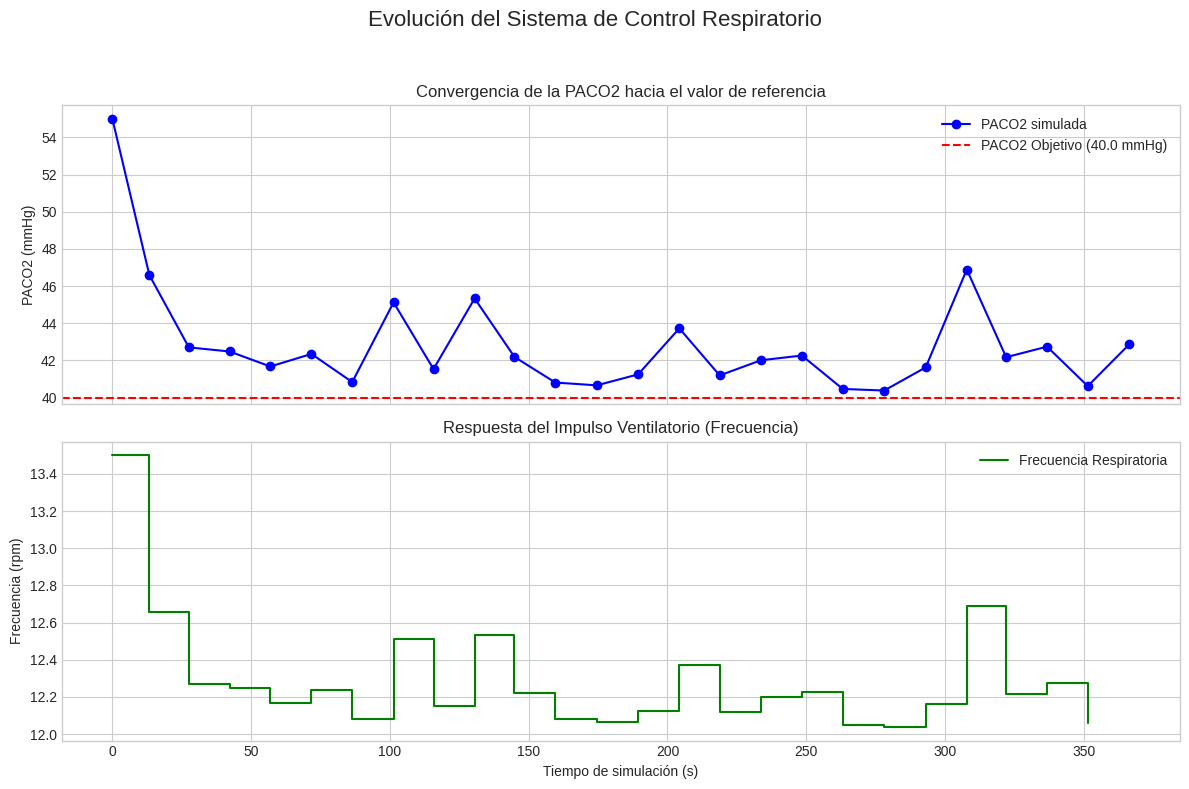

In [8]:
if __name__ == "__main__":

    # Paciente con una patología obstructiva leve (R1 y R2 aumentadas)
    paciente_obstructivo = Paciente(R1=15, C1=0.06, R2=20, C2=0.06)

    # Ventilador en modo espontáneo. Los parámetros de FR y Ti no se usarán
    # directamente, pero T_total define la duración de cada período de simulación.
    ventilador_esp = Ventilador(modo='ESP', PEEP=0)

    # Módulo de Control Respiratorio
    control = ControlRespiratorio(
        PACO2_target=40.0,
        f_base=12.0,
        Gp=0.3,
        Gf=0.1,
        Gi=0.12)

    ## Módulos de intercambio y cardiovascular
    intercambio = IntercambioGases(
        ventilador_esp,
        V_D=0.150,
        VCO2=200.0,
        R=0.8,
        FiO2=0.21,
        Pb=560.0)
    cardio = InteraccionCorazonPulmon(
        GC_base_L_min=5.0,
        k_sensibilidad=0.05,
        hb_g_dl=15.0)

    # Simulador que integra todos los componentes
    simulador_esp = Simulador(paciente_obstructivo, ventilador_esp, control)

    print(" Iniciando simulación de control respiratorio en lazo cerrado")

    num_iteraciones = 25
    # duracion_chunk_s = 10.0 # Cada iteración simula 10 segundos de respiración

    # Estado inicial: el paciente está hipercápnico
    PACO2_actual = 55.0
    V0 = [0.0, 0.0] # Volúmenes iniciales en los compartimentos
    t_global = 0.0

    # Historial para graficar la evolución
    historial_tiempo = [0]
    historial_PACO2 = [PACO2_actual]
    historial_fr = []

    for i in range(num_iteraciones):
        # 1. El controlador define el patrón respiratorio basado en la PACO2
        # El dt para el término integral es la duración del chunk anterior
        dt = 3 * (1.0 / (control.frecuencia if control.frecuencia else f_base/60.0)) if i > 0 else 10.0
        amplitud, frecuencia_hz = control.actualizar(PACO2_actual, dt)
        frecuencia_rpm = frecuencia_hz * 60
        historial_fr.append(frecuencia_rpm)
        T_ciclo = 1.0 / frecuencia_hz
        duracion_chunk_s = 3 * T_ciclo # Simular exactamente 3 ciclos
        print(f"\nIteración {i+1}/{num_iteraciones}: PACO2 inicial: {PACO2_actual:.1f} mmHg -> Frec: {frecuencia_rpm:.1f} rpm")

        #print(f"\nIteración {i+1}/{num_iteraciones}:")
        #print(f"  PACO2 inicial: {PACO2_actual:.1f} mmHg")
        #print(f"  Control -> Amplitud: {amplitud:.1f} cmH2O, Frecuencia: {frecuencia_rpm:.1f} rpm")

        # 2. Simular un período de tiempo con ese patrón respiratorio
        t_start = t_global
        t_end = t_global + duracion_chunk_s
        t_eval = np.linspace(t_start, t_end, int(300 * duracion_chunk_s / T_ciclo)) # Puntos por ciclo

        # Solver de EDO con el modelo del simulador
        sol = solve_ivp(
            simulador_esp._modelo_edo,
            [t_start, t_end],
            V0,
            t_eval=t_eval,
            dense_output=True
        )

        # 3. Procesar resultados para obtener la nueva PACO2
        resultados_mecanica = simulador_esp.procesar_resultados(sol.t, sol.y[0], sol.y[1])

        # FR efectiva para el cálculo de IntercambioGases
        intercambio.ventilador.fr = frecuencia_rpm
        # resultados_gases = intercambio.calcular(resultados_mecanica)
        # Manejo de error si el VT es cero (apnea)
        try:
            resultados_gases = intercambio.calcular(resultados_mecanica)
            nueva_PACO2 = resultados_gases['PACO2_mmHg']
        except ValueError:
            # Si hay apnea, el VT es 0. La VA es negativa.
            # En este caso, la PACO2 subiría. Simulamos un aumento modesto.
            nueva_PACO2 = PACO2_actual + 5.0

        # 4. Actualizar el estado para la siguiente iteración
        # Factor de suavizado (0 < alpha < 1). Un valor bajo = más suave.
        alpha = 0.25 #porque el sistema estaba subamortiguado
        nueva_PACO2 = resultados_gases['PACO2_mmHg']
        PACO2_actual = (alpha * nueva_PACO2) + ((1 - alpha) * PACO2_actual)
        V0 = sol.y[:, -1] # Usar el último estado de volumen como condición inicial
        t_global = t_end

        # Guardar en historial
        historial_tiempo.append(t_global)
        historial_PACO2.append(PACO2_actual)

    print("\n Simulación completada.")

    # --- VISUALIZACIÓN DE RESULTADOS ---
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle('Evolución del Sistema de Control Respiratorio', fontsize=16)

    # Gráfico de PACO2
    axs[0].plot(historial_tiempo, historial_PACO2, 'o-', color='blue', label='PACO2 simulada')
    axs[0].axhline(y=control.PACO2_target, color='red', linestyle='--', label=f'PACO2 Objetivo ({control.PACO2_target} mmHg)')
    axs[0].set_ylabel('PACO2 (mmHg)')
    axs[0].legend()
    axs[0].set_title('Convergencia de la PACO2 hacia el valor de referencia')

    # Gráfico de Frecuencia Respiratoria
    tiempo_fr = np.array(historial_tiempo[:-1])
    axs[1].step(tiempo_fr, historial_fr, where='post', color='green', label='Frecuencia Respiratoria')
    axs[1].set_ylabel('Frecuencia (rpm)')
    axs[1].set_xlabel('Tiempo de simulación (s)')
    axs[1].legend()
    axs[1].set_title('Respuesta del Impulso Ventilatorio (Frecuencia)')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()